In [1]:
!pip install CatBoost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.1 MB/s eta 0:00:00


In [2]:
!pip install XGBoost

**Импорт библиотек**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

**Открытие данных**

In [4]:
df_train = pd.read_csv('train_spam.csv')
df_test = pd.read_csv('test_spam.csv')
df_train.head(10)

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
5,spam,i am so greatful to mrs valerie dodson for hel...
6,ham,url url date not supplied government employees...
7,spam,welcome to jefferson pilot s gateway to wealth...
8,ham,looks like your ham corpus by and large has to...
9,ham,how are you with moneyas in to youmoney aint a...


Проверяю, есть ли пустые значения в двух столбцах

In [5]:
df_train['text_type'].isnull().sum()

0

In [6]:
df_train['text'].isnull().sum()

0

Их нет. Тогда будет проще с ними работать

Меняю столбец с целевыми значениями на бинарные, где spam = 1, ham = 0

In [7]:
df_train = df_train.replace('spam', 1).replace('ham', 0)
df_train.head(10)

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...
5,1,i am so greatful to mrs valerie dodson for hel...
6,0,url url date not supplied government employees...
7,1,welcome to jefferson pilot s gateway to wealth...
8,0,looks like your ham corpus by and large has to...
9,0,how are you with moneyas in to youmoney aint a...


Ищу дубликаты текстов для удаления перед обучением

In [8]:
duplicate = df_train[df_train.duplicated(['text'], keep = False)]
duplicate.head(10)

,text_type,text
1614,0,SPAM DETECTION User: Username: @DillyBubb...
2138,0,/ban
2557,0,SPAM ALERT 🚔 User: Username: @DillyBubbl...
4145,0,SPAM ALERT 🚔 User: Username: @DillyBubbl...
4463,0,SPAM ALERT 🚔 User: Username: @DillyBubbl...
5640,0,/ban
6933,0,SPAM ALERT 🚔 User: Username: @DillyBubbl...
7663,0,SPAM ALERT 🚔 User: Username: @DillyBubbl...
7918,0,SPAM ALERT 🚔 User: Username: @DillyBubbl...
9790,0,SPAM ALERT 🚔 User: Username: @DillyBubbl...


In [9]:
pd.set_option('display.max_colwidth', None)
df_errors = df_train.groupby('text').filter(lambda x: x['text_type'].nunique() > 1, display)
df_errors.head(20)

,text_type,text


Удаляю дубликаты

In [10]:
df_train = df_train.drop_duplicates(subset='text')
df_train.shape

(16267, 2)

Создаю колонку длины текстов, чтобы посчитать длину каждого текста

In [11]:
df_train["TextLength"]=df_train["text"].apply(len)
df_train.head()

,text_type,text,TextLength
0,0,make sure alex knows his birthday is over in fifteen minutes as far as youre concerned,86
1,0,a resume for john lavorato thanks vince i will get moving on it right away molly vince j kaminski 02 21 2001 05 55 pm to molly magee hou ect ect cc vince j kaminski hou ect ect subject a resume for john lavorato molly please make arrangements for the interview with this candidate for a trading position interviews with john lavorato jeff shankman gary hickerson stinson gibner i talked to him in new york and he is considering other opportunities so we have to act fast i think john will like him more than punit thanks,520
2,1,plzz visit my website moviesgodml to get all movies for free and also i provide direct download links no redirect and ads😊😊😊😊😁,126
3,1,urgent your mobile number has been awarded with a £2000 prize guaranteed call 09061790121 from land line claim 3030 valid 12hrs only 150ppm,139
4,0,overview of hr associates analyst project per david s request attached is an overview of the hr associates analysts project creating a human resource value index this document will provide a brief top line overview of the following description of the challenges people involved positive outcomes high level description of the process we suggest if you have any questions before our tuesday meeting please contact either myself or dan brown thanks tana cashion david oxley ect 10 05 2000 10 20 am to gerry gibson corp enron enron cc andrea yowman corp enron enron bob sparger corp enron enron tim o rourke corp enron enron ted c bland hou ect ect daniel brown na enron enron tana cashion na enron enron rhonna palmer hou ect ect cindy,733


Небольшой EDA по тексту. Хочу посмотреть длину каждого сообщения, количество букв и Спам/Не спам

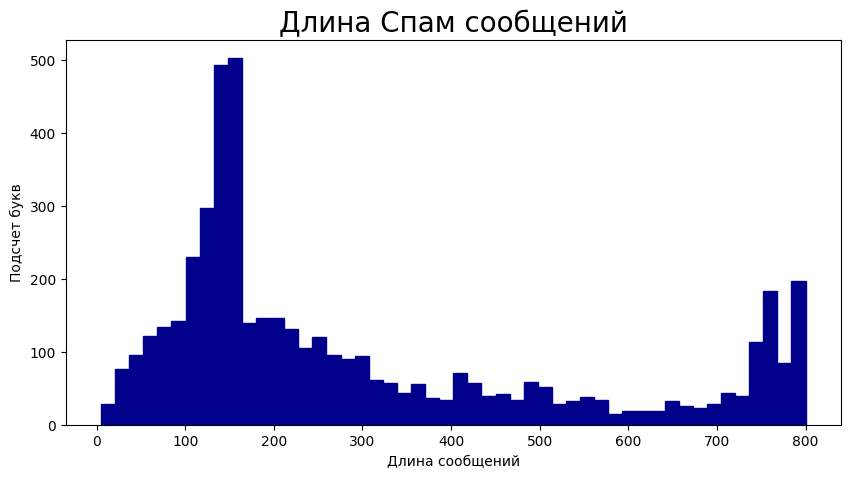

In [12]:
plt.figure(figsize=[10,5])
plt.hist(df_train[df_train['text_type']==1]['TextLength'],color='darkblue',bins=50,edgecolor='darkblue')
plt.title('Длина Спам сообщений',fontsize=20)
plt.xlabel('Длина сообщений')
plt.ylabel('Подсчет букв')
plt.show()

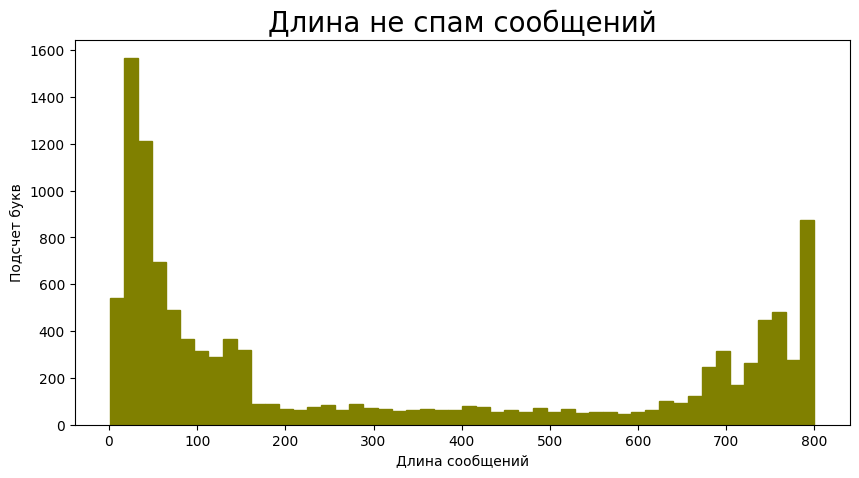

In [13]:
plt.figure(figsize=[10,5])
plt.hist(df_train[df_train['text_type']==0]['TextLength'],color='olive',bins=50,edgecolor='olive')
plt.title('Длина не спам сообщений',fontsize=20)
plt.xlabel('Длина сообщений')
plt.ylabel('Подсчет букв')
plt.show()

Процент длин слов по спам и не спам

In [14]:
print( 'ham percentage word length =',sum(df_train[df_train['text_type']==0]['TextLength'])/sum(df_train['TextLength']))
print( 'Spam percentage word length =',sum(df_train[df_train['text_type']==1]['TextLength'])/sum(df_train['TextLength']))

ham percentage word length = 0.7130470285615057
Spam percentage word length = 0.28695297143849424


Сумма длин всех букв

In [15]:
print(df_train['text'].apply(lambda x: len(x.split(' '))).sum())

924836


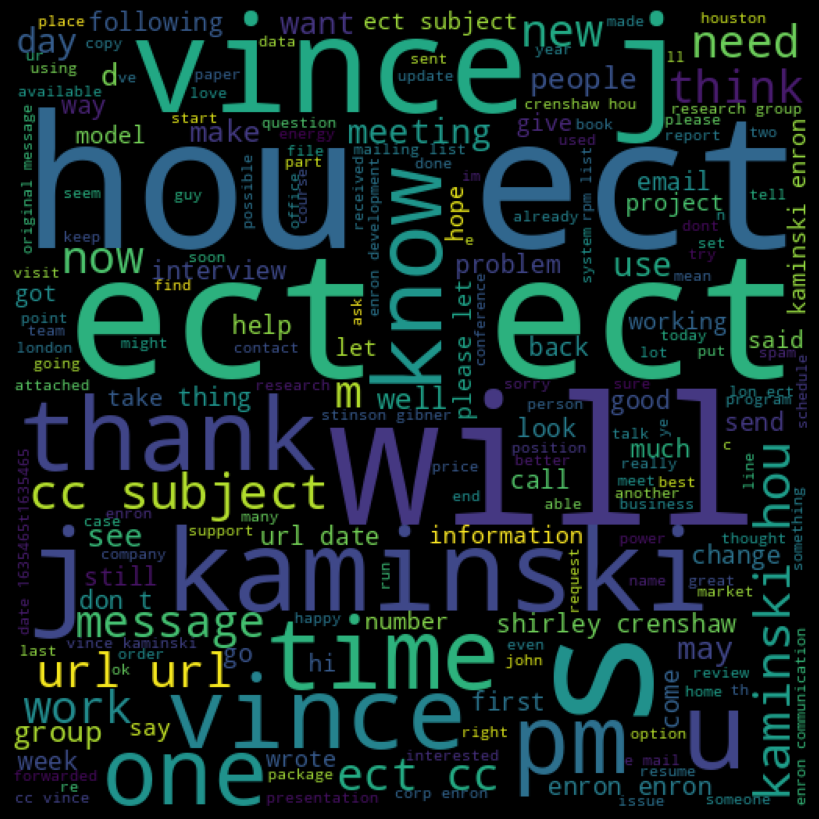

In [16]:
ham_words = ' '.join(list(df_train[df_train['text_type'] == 0]['text']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

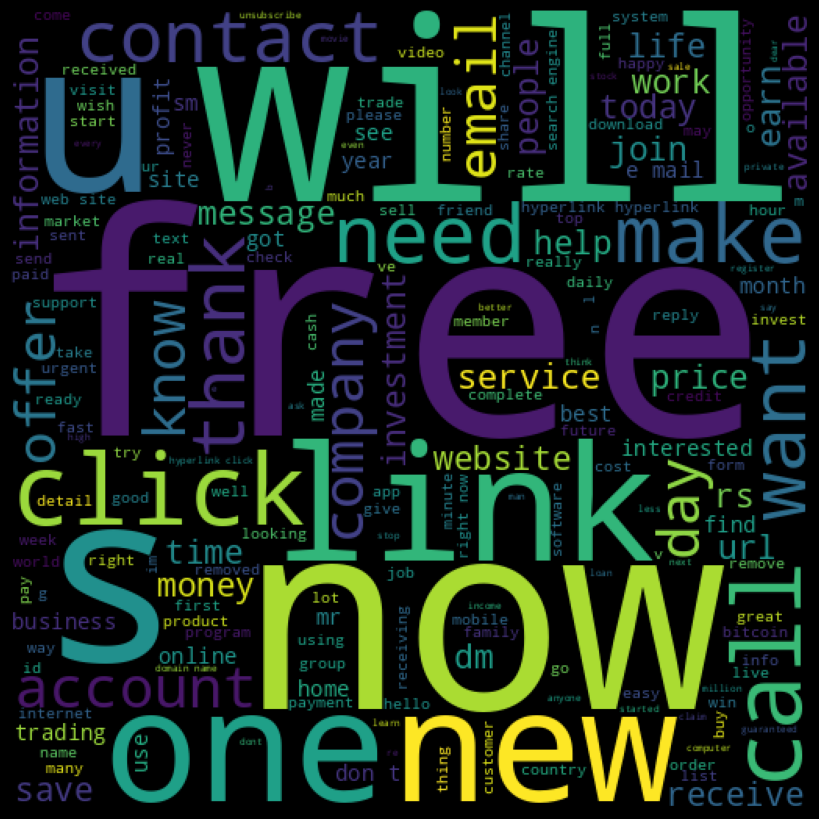

In [17]:
ham_words = ' '.join(list(df_train[df_train['text_type'] == 1]['text']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Предобработка текста. Создаю функцию clean, чтобы очистить текст от различных видов ссылок, пунктуации, больших букв и многое другое

In [18]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean(text):
  if not isinstance(text, str):
    return str(text) if text is not None else ''

  words = word_tokenize(text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'@\S+', '', text)
  text = re.sub(r'#\S+', '', text)
  text = re.sub(f'[{string.punctuation}]', '', text)
  text = text.lower()
  words = [w for w in words if w not in stop_words]

  return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
df_train['cleaned_text'] = df_train['text'].apply(clean) # Добавляю новую колонку с очищенным текстом дял train и test
df_test['cleaned_text'] = df_test['text'].apply(clean)

Попробую сделать TF-IDF векторизацию текста

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df_train['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['cleaned_text'])

In [21]:
X = X_tfidf
y = df_train['text_type']

Разделю выборку по старинке (80/20)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((13013, 5000), (13013,))

Обучаю модели и получаю предсказания. Всего я использовал 9 моделей классификации. Для ROC-AUC score я сохраняю вероятности только для положительного исхода (spam)

In [23]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred_1 = lg.predict_proba(X_test)[:,1]
y_pred_lg = lg.predict(X_test)

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

lr_auc_lg = roc_auc_score(y_test, y_pred_1)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc_lg))

LogisticRegression: ROC AUC=0.976


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2271
           1       0.94      0.81      0.87       983

    accuracy                           0.93      3254
   macro avg       0.93      0.89      0.91      3254
weighted avg       0.93      0.93      0.93      3254



In [26]:
knn = KNeighborsClassifier(weights='uniform', n_neighbors=30, leaf_size=40, algorithm='brute')
knn.fit(X_train, y_train)
y_pred_2 = knn.predict_proba(X_test)[:,1]
y_pred_knn = knn.predict(X_test)

In [27]:
lr_auc_knn = roc_auc_score(y_test, y_pred_2)
print('KNN: ROC AUC=%.3f' % (lr_auc_knn))

KNN: ROC AUC=0.746


In [28]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2271
           1       0.98      0.06      0.12       983

    accuracy                           0.72      3254
   macro avg       0.85      0.53      0.47      3254
weighted avg       0.79      0.72      0.62      3254



In [29]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_3 = svm.predict_proba(X_test)[:, 1]
y_pred_svm = svm.predict(X_test)

In [30]:
lr_auc_svm = roc_auc_score(y_test, y_pred_3)
print('SVM: ROC AUC=%.3f' % (lr_auc_svm))

SVM: ROC AUC=0.983


In [31]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2271
           1       0.96      0.86      0.91       983

    accuracy                           0.95      3254
   macro avg       0.95      0.92      0.94      3254
weighted avg       0.95      0.95      0.95      3254



In [32]:
from sklearn.calibration import CalibratedClassifierCV
sgd = SGDClassifier(loss='hinge')
clf = sgd.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
sgd = calibrator.fit(X_train, y_train)
y_pred_4 = sgd.predict_proba(X_test)[:, 1]
y_pred_sgd = sgd.predict(X_test)

In [33]:
lr_auc_sgd = roc_auc_score(y_test, y_pred_4)
print('SGDClassifier: ROC AUC=%.3f' % (lr_auc_sgd))

SGDClassifier: ROC AUC=0.978


In [34]:
print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2271
           1       0.92      0.88      0.90       983

    accuracy                           0.94      3254
   macro avg       0.93      0.92      0.93      3254
weighted avg       0.94      0.94      0.94      3254



In [35]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)
y_pred_5 = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

In [36]:
lr_auc_rf = roc_auc_score(y_test, y_pred_5)
print('RandomForestClassifier: ROC AUC=%.3f' % (lr_auc_rf))

RandomForestClassifier: ROC AUC=0.981


In [37]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2271
           1       0.95      0.85      0.90       983

    accuracy                           0.94      3254
   macro avg       0.95      0.91      0.93      3254
weighted avg       0.94      0.94      0.94      3254



In [38]:
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)
y_pred_6 = ab.predict_proba(X_test)[:, 1]
y_pred_ab = ab.predict(X_test)

In [39]:
lr_auc_ab = roc_auc_score(y_test, y_pred_6)
print('AdaBoostClassifier: ROC AUC=%.3f' % (lr_auc_ab))

AdaBoostClassifier: ROC AUC=0.911


In [40]:
print(classification_report(y_test, y_pred_ab))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2271
           1       0.86      0.68      0.76       983

    accuracy                           0.87      3254
   macro avg       0.87      0.82      0.84      3254
weighted avg       0.87      0.87      0.87      3254



In [41]:
!pip install CatBoost

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, min_samples_leaf=8, min_samples_split=8, n_estimators=171, subsample=0.8)
gb.fit(X_train, y_train)
y_pred_7 = gb.predict_proba(X_test)[:, 1]
y_pred_gb = gb.predict(X_test)

In [43]:
lr_auc_gb = roc_auc_score(y_test, y_pred_7)
print('GradientBoostingClassifier: ROC AUC=%.3f' % (lr_auc_gb))

GradientBoostingClassifier: ROC AUC=0.967


In [44]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2271
           1       0.96      0.72      0.82       983

    accuracy                           0.91      3254
   macro avg       0.93      0.85      0.88      3254
weighted avg       0.91      0.91      0.90      3254



In [45]:
cb = CatBoostClassifier(learning_rate=0.1, depth=5)
cb.fit(X_train, y_train)
y_pred_8 = cb.predict_proba(X_test)[:, 1]
y_pred_cb = cb.predict(X_test)

0:	learn: 0.6405969	total: 329ms	remaining: 5m 28s
1:	learn: 0.6101493	total: 480ms	remaining: 3m 59s
2:	learn: 0.5724957	total: 631ms	remaining: 3m 29s
3:	learn: 0.5563974	total: 777ms	remaining: 3m 13s
4:	learn: 0.5432767	total: 922ms	remaining: 3m 3s
5:	learn: 0.5308840	total: 1.09s	remaining: 3m
6:	learn: 0.5209772	total: 1.24s	remaining: 2m 56s
7:	learn: 0.5116568	total: 1.38s	remaining: 2m 51s
8:	learn: 0.5030032	total: 1.54s	remaining: 2m 49s
9:	learn: 0.4958756	total: 1.7s	remaining: 2m 47s
10:	learn: 0.4801114	total: 1.85s	remaining: 2m 46s
11:	learn: 0.4734891	total: 2s	remaining: 2m 44s
12:	learn: 0.4677697	total: 2.16s	remaining: 2m 44s
13:	learn: 0.4625214	total: 2.3s	remaining: 2m 42s
14:	learn: 0.4565035	total: 2.45s	remaining: 2m 41s
15:	learn: 0.4515355	total: 2.6s	remaining: 2m 40s
16:	learn: 0.4462364	total: 2.75s	remaining: 2m 39s
17:	learn: 0.4419751	total: 2.9s	remaining: 2m 38s
18:	learn: 0.4374480	total: 3.06s	remaining: 2m 37s
19:	learn: 0.4337524	total: 3.21s	

In [46]:
lr_auc_cb = roc_auc_score(y_test, y_pred_8)
print('CatBoostClassifier: ROC AUC=%.3f' % (lr_auc_cb))

CatBoostClassifier: ROC AUC=0.979


In [47]:
print(classification_report(y_test, y_pred_cb))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2271
           1       0.96      0.83      0.89       983

    accuracy                           0.94      3254
   macro avg       0.95      0.91      0.92      3254
weighted avg       0.94      0.94      0.94      3254



In [50]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_9 = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb.predict(X_test)

In [51]:
lr_auc_xgb = roc_auc_score(y_test, y_pred_9)
print('CatBoostClassifier: ROC AUC=%.3f' % (lr_auc_xgb))

CatBoostClassifier: ROC AUC=0.973


In [52]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2271
           1       0.96      0.80      0.87       983

    accuracy                           0.93      3254
   macro avg       0.94      0.89      0.91      3254
weighted avg       0.93      0.93      0.93      3254



Строим графики ROC-AUC для всех моделей

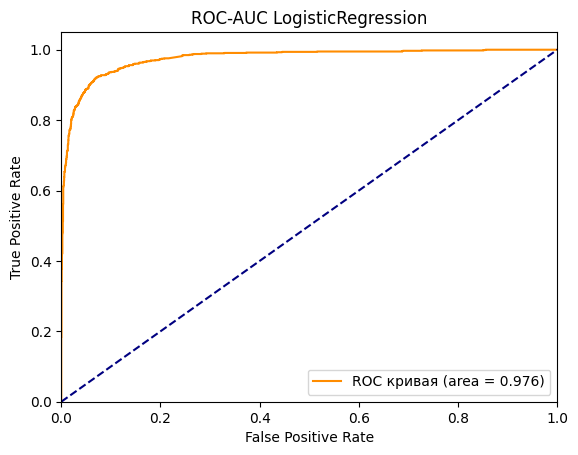

In [53]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC LogisticRegression')
plt.legend(loc="lower right")
plt.show()

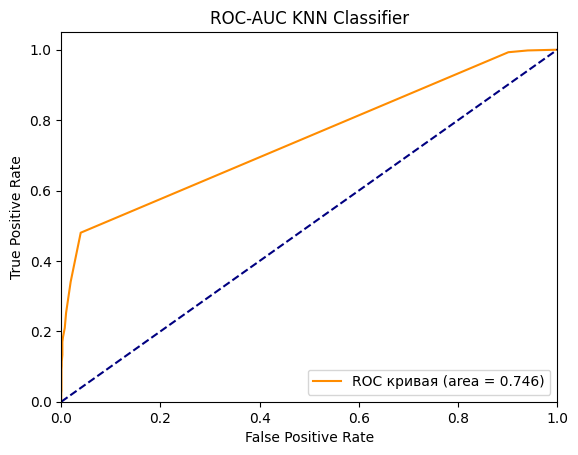

In [54]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_2)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC KNN Classifier')
plt.legend(loc="lower right")
plt.show()

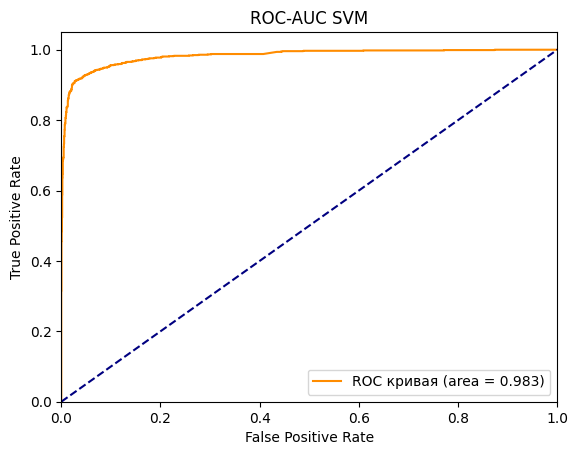

In [55]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_3)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC SVM')
plt.legend(loc="lower right")
plt.show()

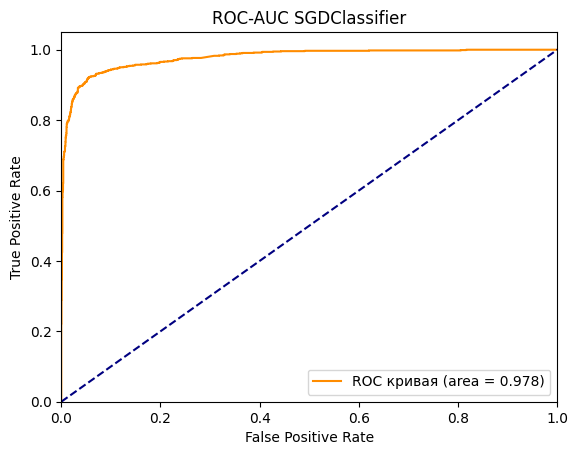

In [56]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_4)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC SGDClassifier')
plt.legend(loc="lower right")
plt.show()

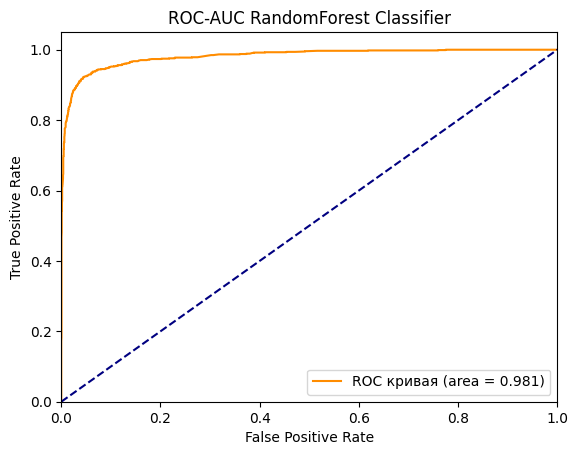

In [57]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_5)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC RandomForest Classifier')
plt.legend(loc="lower right")
plt.show()

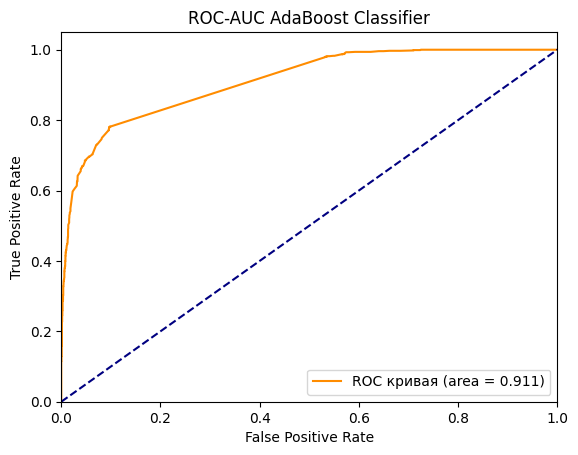

In [58]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_6)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC AdaBoost Classifier')
plt.legend(loc="lower right")
plt.show()

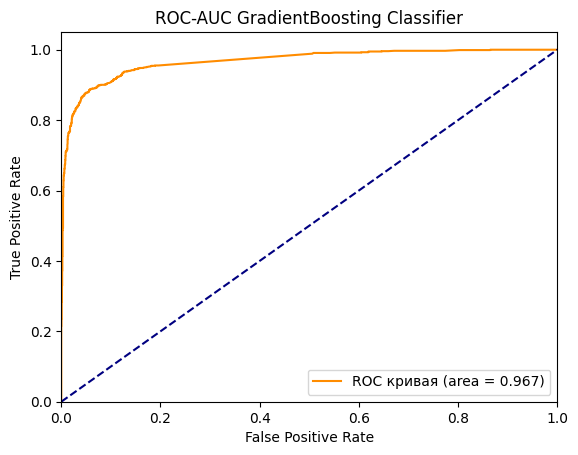

In [59]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_7)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC GradientBoosting Classifier')
plt.legend(loc="lower right")
plt.show()

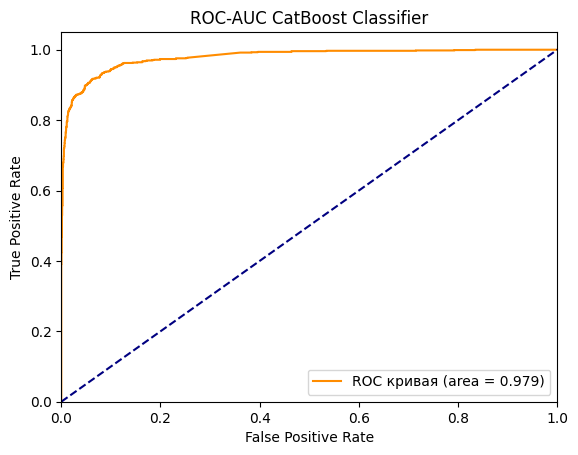

In [60]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_8)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC CatBoost Classifier')
plt.legend(loc="lower right")
plt.show()

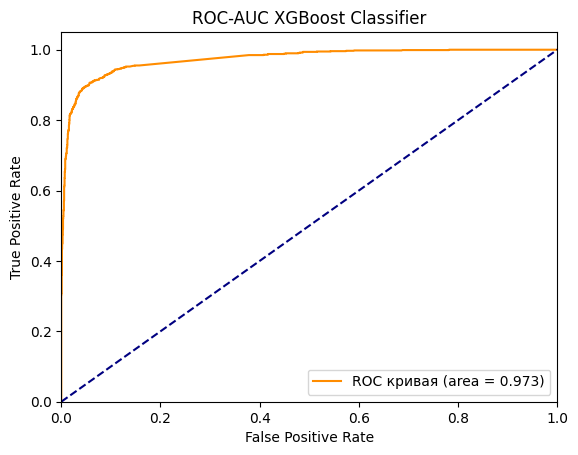

In [61]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_9)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC XGBoost Classifier')
plt.legend(loc="lower right")
plt.show()

Строю матрицы ошибок для каждой модели

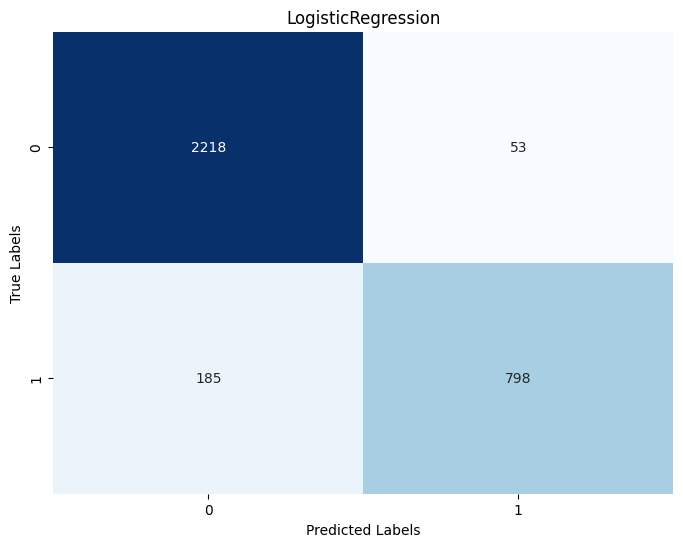

In [62]:
import seaborn as sns
conf_matrix_lg = confusion_matrix(y_test, y_pred_lg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lg, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('LogisticRegression')
plt.show()

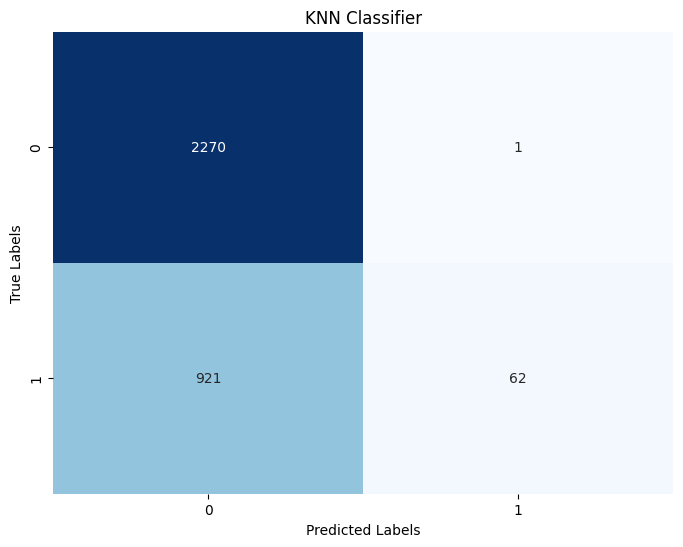

In [63]:
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('KNN Classifier')
plt.show()

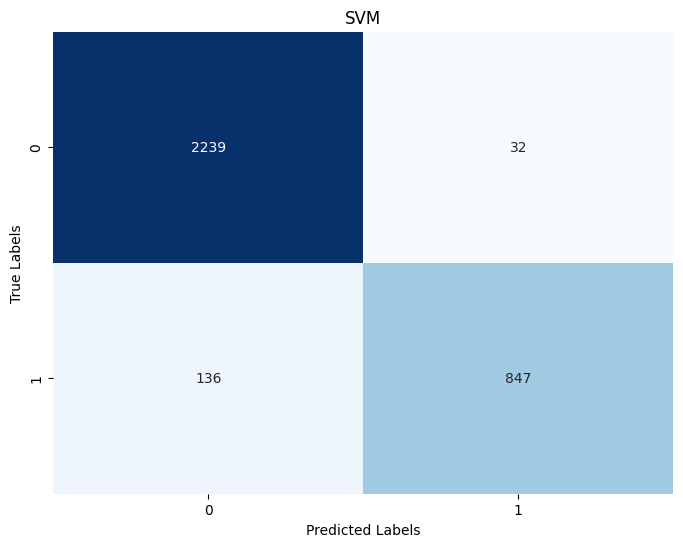

In [64]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM')
plt.show()

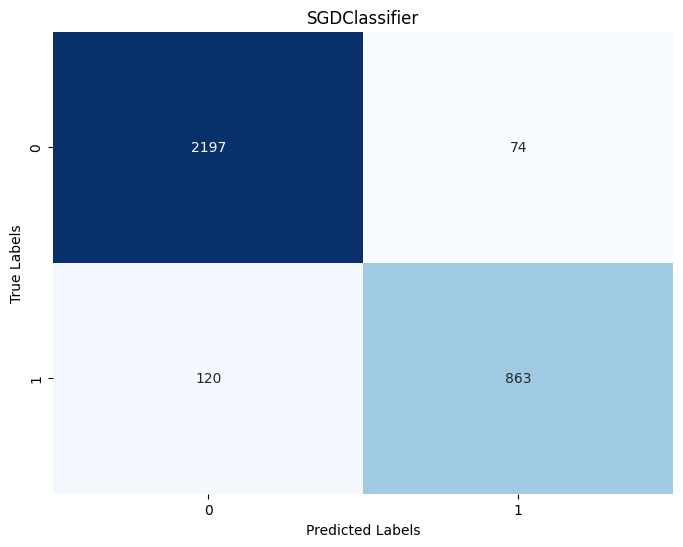

In [65]:
conf_matrix_sgd = confusion_matrix(y_test, y_pred_sgd)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_sgd, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SGDClassifier')
plt.show()

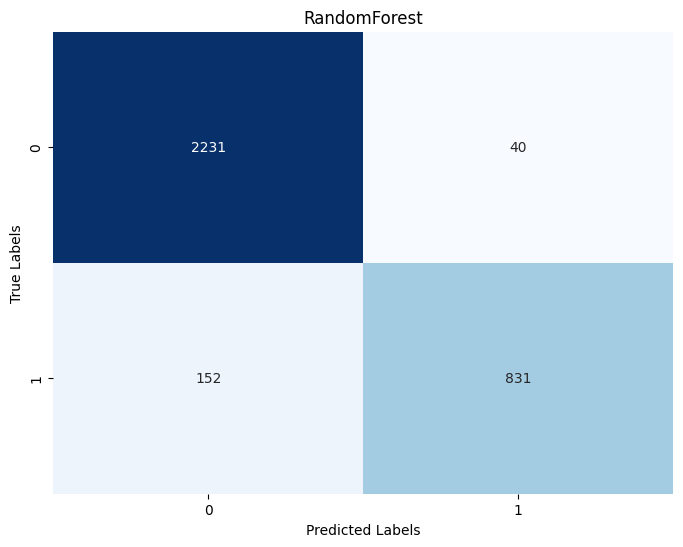

In [66]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('RandomForest')
plt.show()

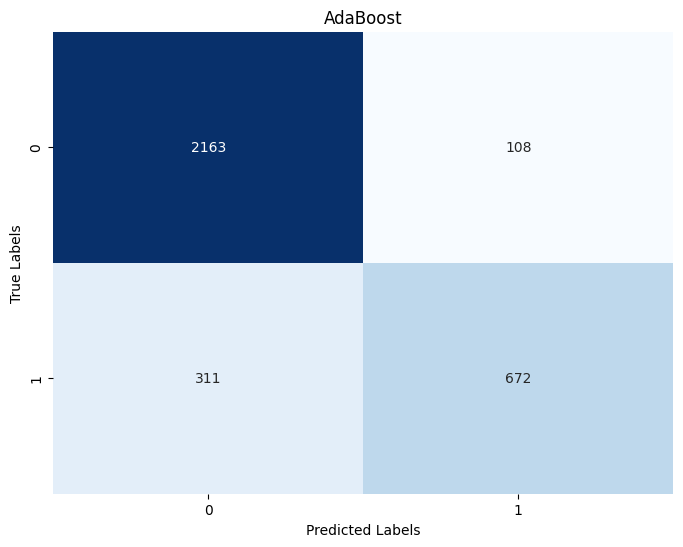

In [67]:
conf_matrix_ab = confusion_matrix(y_test, y_pred_ab)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ab, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('AdaBoost')
plt.show()

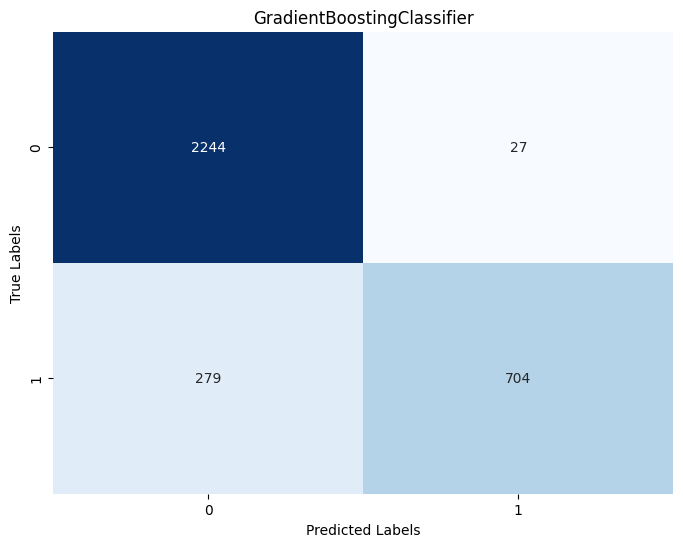

In [68]:
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('GradientBoostingClassifier')
plt.show()

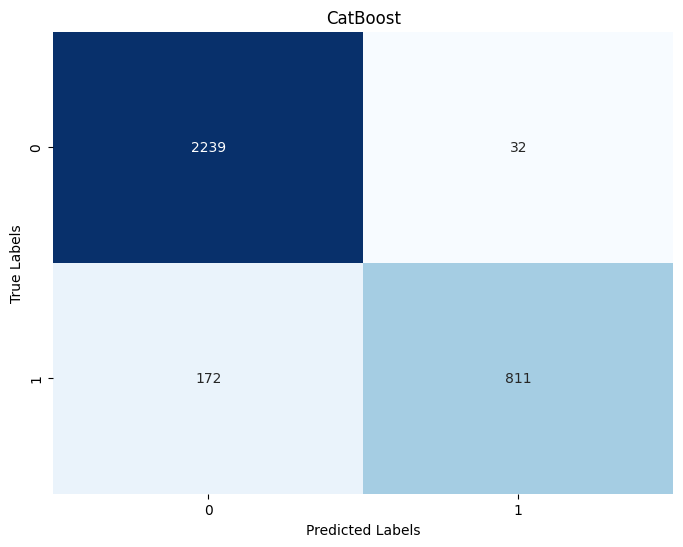

In [69]:
conf_matrix_cb = confusion_matrix(y_test, y_pred_cb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CatBoost')
plt.show()

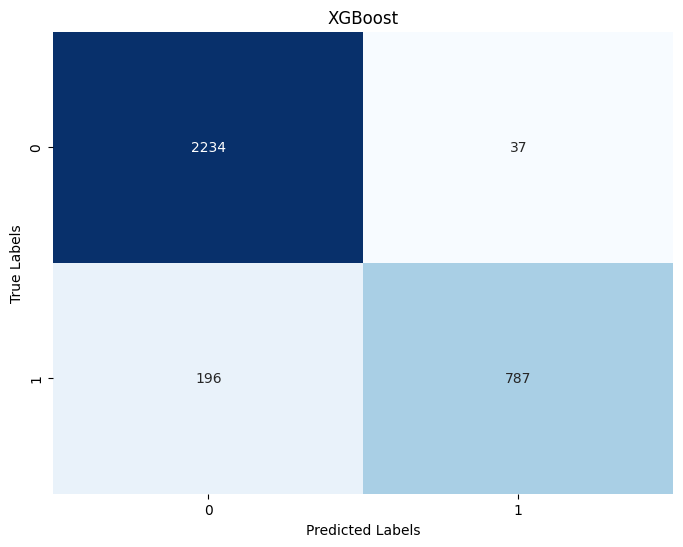

In [70]:
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XGBoost')
plt.show()

Создам датасет из двух столбцов, которые включают в себя 2 столбца: используемый метод классификации и ROC-AUC Score

In [71]:
models = ["LogisticRegression", "KNNClassifier", "SVM", "SGDClassifier", "RandomForestClassifier", "AdaBoostClassifier",
          "GradientBoostingClassifier", "CatBoostClassifier", "XGBoostClassifier"]
ROC_AUC_list = []
ROC_AUC_list.append(lr_auc_lg)
ROC_AUC_list.append(lr_auc_knn)
ROC_AUC_list.append(lr_auc_svm)
ROC_AUC_list.append(lr_auc_svm)
ROC_AUC_list.append(lr_auc_rf)
ROC_AUC_list.append(lr_auc_ab)
ROC_AUC_list.append(lr_auc_gb)
ROC_AUC_list.append(lr_auc_cb)
ROC_AUC_list.append(lr_auc_xgb)

results_df = pd.DataFrame({
    'Model': models,
    'ROC_AUC_Score': ROC_AUC_list
})

max_roc_index = results_df['ROC_AUC_Score'].idxmax()
min_roc_index = results_df['ROC_AUC_Score'].idxmin()

styled_df = results_df.style.apply(lambda x: ['background-color: green' if x.name == max_roc_index else
                                              'background-color: lightcoral' if x.name == min_roc_index else
                                              '' for _ in x], axis=1)
styled_df

,Model,ROC_AUC_Score
0,LogisticRegression,0.975522
1,KNNClassifier,0.746217
2,SVM,0.982527
3,SGDClassifier,0.982527
4,RandomForestClassifier,0.980876
5,AdaBoostClassifier,0.911114
6,GradientBoostingClassifier,0.967143
7,CatBoostClassifier,0.978661
8,XGBoostClassifier,0.973361


SVM является лучшим алгоритмом по метрике ROC-AUC score (он выделен зеленым цветом). KNN - самый худший (кораловый цвет). Теперь беру эту модель и обучаю на тестовых данных. Создаю датафрейм из двух столбцов: текст сообщений и score

In [72]:
X_val = X_test_tfidf
text = df_test['text']

In [73]:
pred = svm.predict_proba(X_val)[:, 1]
binary = (pred > 0.5).astype(int)

result = pd.DataFrame({'score': binary.flatten(), 'text': text})
result.head(10)

,score,text
0,0,j jim whitehead ejw cse ucsc edu writes j you open sourced the new components you developed for this j project so the next person who comes along won t have to j reimplement them right no need all those components already exist either in the java class libraries or from the various java jar collections most of the classes i used came from the jakarta project and apachexml but if it s any consolation my threading of them all together into a newswire server is gpl and available on sourceforge gary lawrence murphy garym teledyn com teledynamics communications inc business advantage through community software url computers are useless they can only give you answers pablo picasso
1,0,original message from bitbitch magnesium net people are screaming and shouting over the political figures because they cannot be heard in any other way what are they illiterate mute what s their problem if somebody stops them from posting web pages or printing newsletters or talking on the phone or organizing their own conference then that would be wrong i don t think free speech is a license to speak directly at and be in the physical presence of any particular individual of your choosing especially when that individual is busy doing something else and isn t interested
2,0,java for managers vince durasoft who just taught the java class for our group offers a 3 day short course in java for managers details are below if you are interested stinsonforwarded by stinson gibner hou ect on 04 16 2001 12 16 pm siva thiagarajan on 04 16 2001 11 25 50 am please respond to siva thiagarajan to cc subject java for managers hi stinson thanks for meeting with us on thursday we enjoyed talking with you as per our discussion i have attached the course outline of java for managers along with this email after our conversation with you we think this course may be a little bit heavy for your group but we can definetly take it down to concepts level and make it appropria
3,0,there is a youtuber name saiman says
4,1,underpriced issue with high return on equity the oil and gas advisory now that oil and gas has entered a long term bul market our speciaity in pinpointing the hottest companies of the few remaining undervaiued energy plays has produced soaring returns emerson oi and gas eogi is an energy developer in the us oil belt and in canada s most highiy coveted reservoirs with generating potentia of millions per week breaking news emerson oil and gas inc eogi is pleased to announce that the aiberta energy utiiity board has issued license no o 330206 for the company s we 11 16 24 2 the acadia project the acadia project consists of 15 sections in aiberta in an area that produces natura gas from the viking formation has oi potentia in the bakken zone and g
5,0,aight lemme know whats up
6,0,hey girl how r u hope u r well me an del r bak again long time no c give me a call sum time from lucyxx
7,0,carnegie mellon recruiting good afternoon i have forwarded your email to kristin gandy she is heading up our cmu recruiting effort some contact info 713 345 3214 kristin gandy enron com we are very interested in the comp fin students and would tentatively like to interview them in december probably the week of the 11 th and around the same time that we come to interview the mba s i m uncertain as to the proper path forward could you provide some details regards kevin kindall sallygould on 11 16 2000 03 38 44 pm to kevin kindall enron com cc subject carnegie mellon recruiting kevin jean eisel asked that i connect with you about recruiting comp finance students please contact me with questions you might have about the recruiting process or
8,0,cv of rodney greene re quantitative positions vince would you have any interest in this candidate kind regards amyforwarded by amy fitzpatrick lon ect on 21 02 2000 09 34 bryan seyfried 18 02 2000 19 50 to amy fitzpatrick lon ect ect cc subject cv of rodney greene re quantitative positions probably a bit to techy for me but maybe a

Получил тестовый датасет с бинарными значениями, где 0 - ham, 1 - spam. Сохраню датасет в двух вариантах:
1. С бинарными значениями score (0 и 1)
2. С флажками spam и ham

In [74]:
result.to_csv('result_with_binary.csv')

In [75]:
result = result.replace(0, 'ham').replace(1, 'spam')
result.head(10)

,score,text
0,ham,j jim whitehead ejw cse ucsc edu writes j you open sourced the new components you developed for this j project so the next person who comes along won t have to j reimplement them right no need all those components already exist either in the java class libraries or from the various java jar collections most of the classes i used came from the jakarta project and apachexml but if it s any consolation my threading of them all together into a newswire server is gpl and available on sourceforge gary lawrence murphy garym teledyn com teledynamics communications inc business advantage through community software url computers are useless they can only give you answers pablo picasso
1,ham,original message from bitbitch magnesium net people are screaming and shouting over the political figures because they cannot be heard in any other way what are they illiterate mute what s their problem if somebody stops them from posting web pages or printing newsletters or talking on the phone or organizing their own conference then that would be wrong i don t think free speech is a license to speak directly at and be in the physical presence of any particular individual of your choosing especially when that individual is busy doing something else and isn t interested
2,ham,java for managers vince durasoft who just taught the java class for our group offers a 3 day short course in java for managers details are below if you are interested stinsonforwarded by stinson gibner hou ect on 04 16 2001 12 16 pm siva thiagarajan on 04 16 2001 11 25 50 am please respond to siva thiagarajan to cc subject java for managers hi stinson thanks for meeting with us on thursday we enjoyed talking with you as per our discussion i have attached the course outline of java for managers along with this email after our conversation with you we think this course may be a little bit heavy for your group but we can definetly take it down to concepts level and make it appropria
3,ham,there is a youtuber name saiman says
4,spam,underpriced issue with high return on equity the oil and gas advisory now that oil and gas has entered a long term bul market our speciaity in pinpointing the hottest companies of the few remaining undervaiued energy plays has produced soaring returns emerson oi and gas eogi is an energy developer in the us oil belt and in canada s most highiy coveted reservoirs with generating potentia of millions per week breaking news emerson oil and gas inc eogi is pleased to announce that the aiberta energy utiiity board has issued license no o 330206 for the company s we 11 16 24 2 the acadia project the acadia project consists of 15 sections in aiberta in an area that produces natura gas from the viking formation has oi potentia in the bakken zone and g
5,ham,aight lemme know whats up
6,ham,hey girl how r u hope u r well me an del r bak again long time no c give me a call sum time from lucyxx
7,ham,carnegie mellon recruiting good afternoon i have forwarded your email to kristin gandy she is heading up our cmu recruiting effort some contact info 713 345 3214 kristin gandy enron com we are very interested in the comp fin students and would tentatively like to interview them in december probably the week of the 11 th and around the same time that we come to interview the mba s i m uncertain as to the proper path forward could you provide some details regards kevin kindall sallygould on 11 16 2000 03 38 44 pm to kevin kindall enron com cc subject carnegie mellon recruiting kevin jean eisel asked that i connect with you about recruiting comp finance students please contact me with questions you might have about the recruiting process or
8,ham,cv of rodney greene re quantitative positions vince would you have any interest in this candidate kind regards amyforwarded by amy fitzpatrick lon ect on 21 02 2000 09 34 bryan seyfried 18 02 2000 19 50 to amy fitzpatrick lon ect ect cc subject cv of rodney greene re quantitative positions probably a bit to techy

In [76]:
result.to_csv('resultFlags.csv')